# Clase 22: Regresión Espacial


In [4]:
#!pip install spreg

In [3]:
import pysal
import numpy as np
from pysal import spreg
#from pysal.model import spreg

import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import seaborn as sns

In [4]:
dat=gpd.read_file('regression_db.geojson')
dat

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,id,pg_Apartment,pg_Condominium,pg_House,pg_Other,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry
0,5,2.0,2.0,2.0,North Hills,0,2.972077,0,425.0,6.052089,6,0,0,1,0,0,1,0,0,POINT (-117.12971 32.75399)
1,6,1.0,2.0,4.0,Mission Bay,0,11.501385,1,205.0,5.323010,5570,0,1,0,0,0,1,0,0,POINT (-117.25253 32.78421)
2,2,1.0,1.0,1.0,North Hills,0,2.493893,0,99.0,4.595120,9553,1,0,0,0,0,0,1,0,POINT (-117.14121 32.75327)
3,2,1.0,1.0,1.0,Mira Mesa,0,22.293757,0,72.0,4.276666,14668,0,0,1,0,0,0,1,0,POINT (-117.15269 32.93110)
4,2,1.0,1.0,1.0,Roseville,0,6.829451,0,55.0,4.007333,38245,0,0,1,0,0,0,1,0,POINT (-117.21870 32.74202)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6105,2,1.0,1.0,1.0,University City,1,16.924951,0,79.0,4.369448,13882013,1,0,0,0,0,0,1,0,POINT (-117.21635 32.87142)
6106,6,2.0,2.0,2.0,Marina,0,2.821975,0,295.0,5.686975,13882245,0,1,0,0,0,1,0,0,POINT (-117.16342 32.71036)
6107,1,1.0,1.0,1.0,North Hills,0,1.990988,0,65.0,4.174387,13882335,0,0,1,0,0,0,1,0,POINT (-117.12986 32.74252)
6108,3,1.0,1.0,1.0,East Village,1,2.060319,0,170.0,5.135798,13882606,1,0,0,0,0,1,0,0,POINT (-117.15070 32.71322)


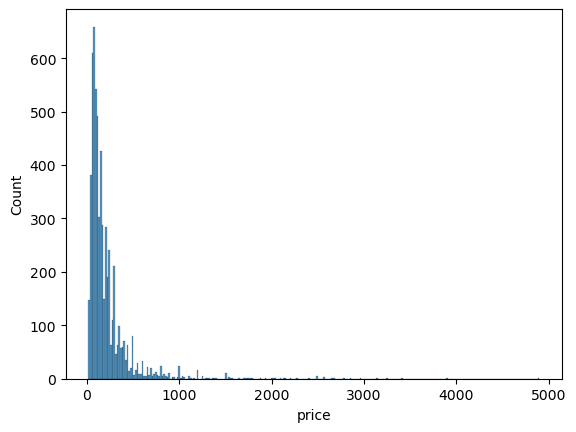

In [5]:
sns.histplot(data=dat,x='price');

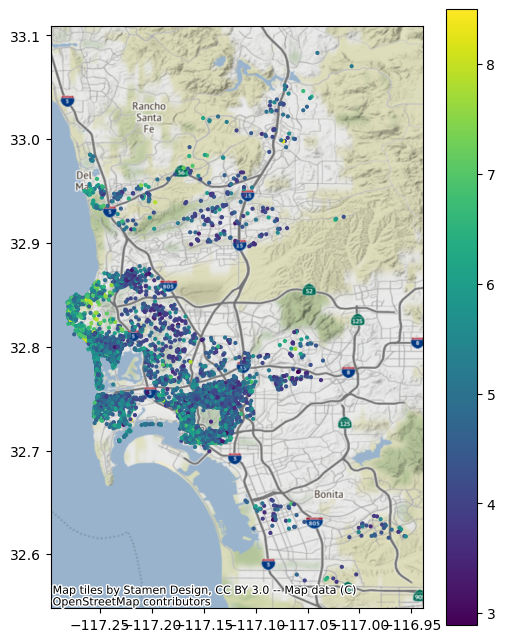

In [6]:
fig=plt.figure(figsize=(6,8))
ax=fig.add_subplot(111)
dat.plot(ax=ax,column='log_price',legend=True,markersize=4);
ctx.add_basemap(ax, crs=dat.crs);


## Regresión no-espacial.

#### Objetivo: 
Explicar la variación en una variables *dependiente*, como una función lineal de una colección de variables *independientes* o *explicativas*.

#### Ejemplo:
Explicar el precio de una casa como una función del nº de habitaciones, y otras características.

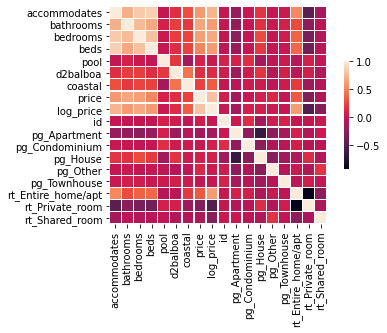

In [16]:
corr = dat.corr()
sns.heatmap(corr, square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [7]:
x_names = [
    "accommodates",  # Number of people it accommodates
    "bathrooms",  # Number of bathrooms
    "bedrooms",  # Number of bedrooms
    "beds",  # Number of beds
    # Below are binary variables, 1 True, 0 False
    "rt_Private_room",  # Room type: private room
    "rt_Shared_room",  # Room type: shared room
    "pg_Condominium",  # Property group: condo
    "pg_House",  # Property group: house
    "pg_Other",  # Property group: other
    "pg_Townhouse",  # Property group: townhouse
]

In [9]:
y = dat['log_price'].values
y.shape = (len(y),1)
X= dat[x_names].values

In [10]:
ls = spreg.ols.OLS(y, X, name_y = 'log_price', name_x = x_names)
print(ls.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :   log_price                Number of Observations:        6110
Mean dependent var  :      4.9958                Number of Variables   :          11
S.D. dependent var  :      0.8072                Degrees of Freedom    :        6099
R-squared           :      0.6683
Adjusted R-squared  :      0.6678
Sum squared residual:    1320.148                F-statistic           :   1229.0564
Sigma-square        :       0.216                Prob(F-statistic)     :           0
S.E. of regression  :       0.465                Log likelihood        :   -3988.895
Sigma-square ML     :       0.216                Akaike info criterion :    7999.790
S.E of regression ML:      0.4648                Schwarz criterion     :    8073.685

-----------------------------------------------------------------------------

In [112]:
b=ls.betas
b.T

array([[ 4.38838296,  0.08345234,  0.19237898,  0.15252209, -0.04172306,
        -0.55068681, -1.23830552,  0.14363474, -0.0104894 ,  0.14115461,
        -0.04167017]])

Este modelo en general funciona bien, logrando predecir ~67% (2/3) de la variación en el precio usando las variables explicativas definidas arriba.
Pero, puede haber cierta aglomeración espacial en los errores, lo cual contradice las suposiciones del modelo lineal original.

#### ¿Hay estructura espacial en los residuos?

Por ejemplo, ¿el modelo falla más al predecir los precios de propiedades cerca de la costa?

In [12]:
dat['res']=ls.u
dat['y_pred']=ls.predy

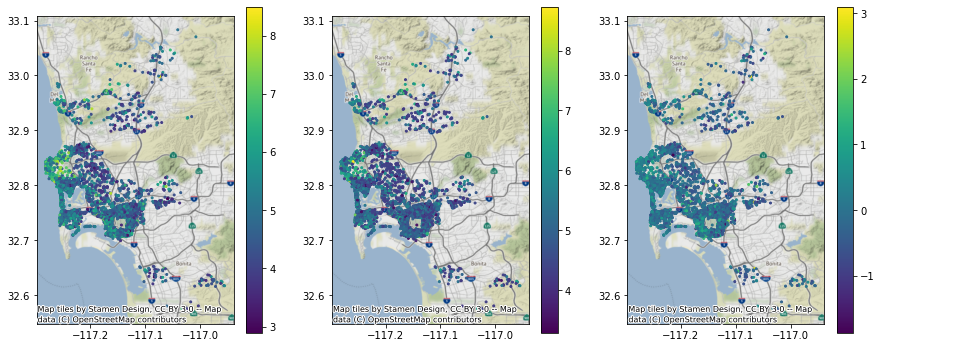

In [22]:
import matplotlib.pyplot as plt
fig,axes=plt.subplots(figsize=(15,6),nrows=1,ncols=3)

dat.plot(ax=axes[0],column='log_price',legend=True,markersize=4)
dat.plot(ax=axes[1],column='y_pred',legend=True,markersize=4)
dat.plot(ax=axes[2],column='res',legend=True,markersize=4);

for ax in axes:
    ctx.add_basemap(ax, crs=dat.crs);


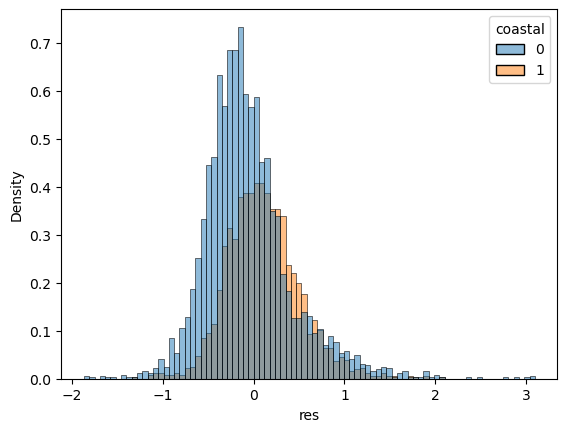

In [13]:
sns.histplot(data=dat,x='res',hue='coastal',stat='density');

**Test T-student:** asume que dos distribuciones independientes son idénticas.

Si el valor-p es cercano a cero, se rechaza la hipótesis con altísima probabilidad.

In [28]:
from scipy.stats import ttest_ind

coastal=dat[dat['coastal']==1]['res']
not_coastal=dat[dat['coastal']==0]['res']

ttest_ind(coastal, not_coastal)

Ttest_indResult(statistic=13.98193857851395, pvalue=9.442438000945613e-44)

#### Más aún,  ¿hay diferencias en los residuos dependediendo del vecindario?

Por ejemplo, debido a preferencias no modeladas, marketing, penalidades asociadas a variables no consideradas (contaminación, ruido, etc).

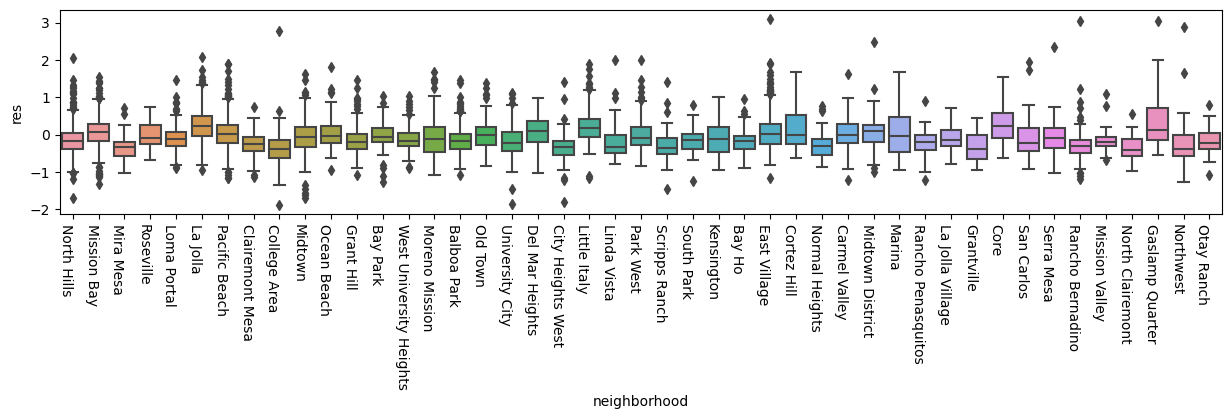

In [17]:
# Set up figure
f = plt.figure(figsize=(15, 3))
# Grab figure's axis
ax = plt.gca()

sns.boxplot(y="res",x="neighborhood",ax=ax,data=dat)
f.autofmt_xdate(rotation=-90);

In [18]:
from libpysal import weights

w=weights.KNN.from_dataframe(dat,k=20)
w.transform='R'

/Users/paguirre/anaconda3/lib/python3.7/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  warnings.warn(message)


In [19]:
import esda 

moran = esda.moran.Moran(dat["res"], w)
moran.I

0.1415908117059347

(-1.869282843800689,
 3.096608617051717,
 -0.6668836666560446,
 0.7023764685418874)

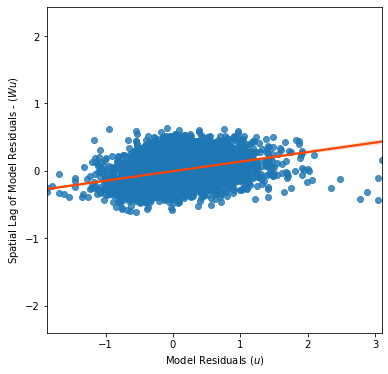

In [53]:
dat['lag_res'] = weights.spatial_lag.lag_spatial(w, dat['res'])

fig=plt.figure(figsize=(6,6))
ax=fig.add_subplot(111)
sns.regplot(x=dat['res'],y=dat['lag_res'],line_kws=dict(color="orangered"))

ax.set_xlabel("Model Residuals ($u$)")
ax.set_ylabel("Spatial Lag of Model Residuals - ($W u$)");
ax.axis('equal')

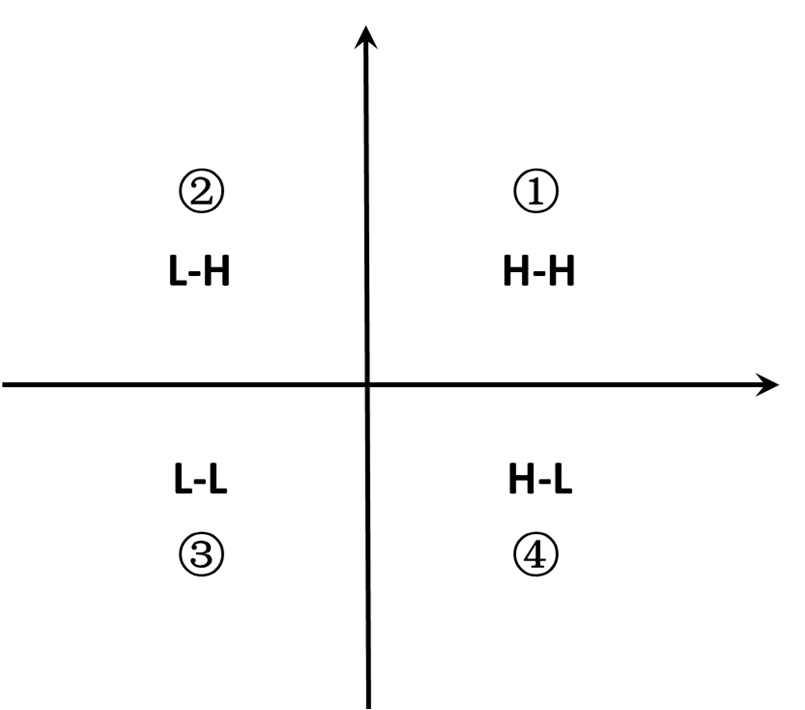

In [20]:
outliers = esda.moran.Moran_Local(dat['res'], w, permutations=999)

In [21]:
dat['q']=outliers.q
dat['p_sim']=outliers.p_sim
dat['local_I']=outliers.Is

In [22]:
error_clusters=dat[(dat.q==1) & (dat.p_sim<=0.001)].sort_values(by="local_I",ascending=False)
error_clusters

,accommodates,bathrooms,bedrooms,beds,neighborhood,pool,d2balboa,coastal,price,log_price,...,pg_Townhouse,rt_Entire_home/apt,rt_Private_room,rt_Shared_room,geometry,res,y_pred,q,p_sim,local_I
1112,3,1.0,0.0,1.0,Gaslamp Quarter,0,2.234856,0,900.0,6.802395,...,0,1,0,0,POINT (-117.16047 32.71506),1.871844,4.930551,1,0.001,3.861911
3360,4,1.0,1.0,2.0,Gaslamp Quarter,0,2.270279,0,599.0,6.395262,...,0,0,1,0,POINT (-117.16076 32.71484),1.821147,4.574115,1,0.001,3.851726
2343,4,1.5,0.0,3.0,Gaslamp Quarter,0,2.187274,0,995.0,6.902743,...,0,1,0,0,POINT (-117.16059 32.71566),1.873516,5.029226,1,0.001,3.463658
1069,2,1.0,1.0,1.0,East Village,0,3.303973,0,165.0,5.105945,...,0,0,0,1,POINT (-117.15838 32.70344),1.485785,3.620160,1,0.001,3.445374
2159,2,1.0,1.0,1.0,Marina,0,2.774850,0,450.0,6.109248,...,0,0,1,0,POINT (-117.16815 32.71426),1.657834,4.451414,1,0.001,3.334497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,4,1.0,2.0,2.0,La Jolla,0,16.277209,1,200.0,5.298317,...,0,1,0,0,POINT (-117.27858 32.82694),0.020993,5.277324,1,0.001,0.045357
5599,4,1.0,0.0,1.0,Gaslamp Quarter,0,2.312563,0,153.0,5.030438,...,0,1,0,0,POINT (-117.16008 32.71399),0.013955,5.016483,1,0.001,0.026611
622,2,1.0,1.0,1.0,Little Italy,1,2.450124,0,75.0,4.317488,...,0,0,1,0,POINT (-117.16996 32.72139),0.009709,4.307779,1,0.001,0.019303
3120,1,1.0,1.0,1.0,La Jolla,0,16.374125,1,68.0,4.219508,...,0,0,1,0,POINT (-117.27955 32.82733),0.005671,4.213837,1,0.001,0.009430


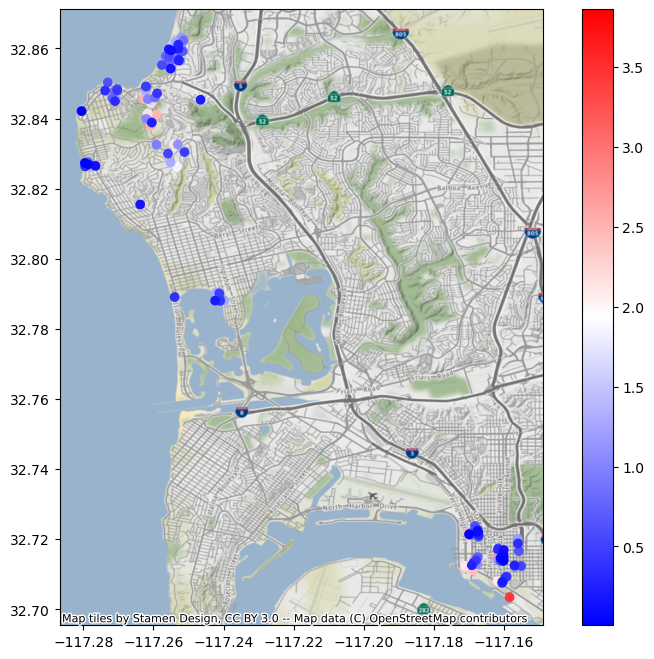

In [23]:
fig=plt.figure(figsize=(10,8))
ax=fig.add_subplot(111)
error_clusters.plot(ax=ax,column='local_I',cmap="bwr",legend=True);
ctx.add_basemap(ax, crs=dat.crs);


## Heterogeneidad espacial.

El modelo puede cambiar significativamente de acuerdo a la geografía.

In [85]:
# spreg spatial fixed effect implementation
m_sh = spreg.OLS_Regimes(
    # Dependent variable
    dat[["log_price"]].values,
    # Independent variables
    dat[x_names].values,
    # Variable specifying neighborhood membership
    
    dat["neighborhood"].tolist(),
    # Allow the constant term to vary by group/regime
    constant_regi="many",
    
    # Variables to be allowed to vary (True) or kept
    # constant (False). Here we set all to False
    cols2regi=[False] * len(x_names),
    
    # Allow separate sigma coefficients to be estimated
    # by regime (False so a single sigma)
    regime_err_sep=False,
    
    # Dependent variable name
    name_y="log_price",
    # Independent variables names
    name_x=x_names,
)